In [3]:
%pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
import math
from scipy import ndimage
from skimage import measure
import numpy as np

In [42]:
def get_file_path(iq_number):
    # Convert number (1-10) to file path "iq_images/iq{i}.png" but with a leading zero if i < 10
    return f"iq_images/iq{str(iq_number).zfill(2)}.png"

def get_image(file_path):
    original_image = cv2.imread(file_path)
    return original_image

def get_grayscale_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def get_contours(image, isGray = False):
    gray = get_grayscale_image(image) if not isGray else image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def align_images(image1, image2, same_shape = False):
    a_contours = get_contours(image1, False)
    b_contours = get_contours(image2, False)
    # Contours includes the black border around the image. Therefore, use the second largest contour
    a_contours = sorted(a_contours, key=cv2.contourArea, reverse=True)
    b_contours = sorted(b_contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(a_contours[1])
    image1 = image1[y:y+h, x:x+w]
    x, y, w, h = cv2.boundingRect(b_contours[1])
    image2 = image2[y:y+h, x:x+w]
    if same_shape:
        # Grow the smaller image to the size of the larger image
        if image1.shape[0] > image2.shape[0]:
            image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
        else:
            image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))
    return image1, image2

def remove_background(image1, image2):
    base = cv2.bitwise_and(image1, image2)
    image1 = cv2.bitwise_xor(image1, base)
    image2 = cv2.bitwise_xor(image2, base)
    return image1, image2

def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def show_images_grid(images):
    # Display the cropped images for visual verification
    grid_size = int(np.sqrt(len(images)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def draw_contours(image, contours, same_color=False):
    # Rainbow colors in BGR format
    rainbow_colors = [
        (0, 0, 255),     # Red
        (0, 165, 255),   # Orange
        (0, 255, 255),   # Yellow
        (0, 255, 0),     # Green
        (255, 0, 0),     # Blue
        (130, 0, 75),    # Indigo
        (238, 130, 238)  # Violet
    ]

    image_with_contours = image.copy()
    
    # Loop through contours and colors
    for i, contour in enumerate(contours):
        color = rainbow_colors[i % len(rainbow_colors)] if not same_color else (0, 255, 0)
        cv2.drawContours(image_with_contours, [contour], -1, color, 2)

    return image_with_contours

In [10]:
def iq_test_to_squares(image):
    # Apply adaptive thresholding to get a binary image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest rectangle contour which should be the grid
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image to the bounding box
    cropped_grid = image[y:y+h, x:x+w]

    # Split the grid into 9 equal parts
    grid_size = 3
    cell_width = w // grid_size
    cell_height = h // grid_size

    # Save each cell as an image
    cells = []
    for i in range(grid_size):
        for j in range(grid_size):
            cell = cropped_grid[i*cell_height:(i+1)*cell_height, j*cell_width:(j+1)*cell_width]
            edge_remove = 6 # remove a number of pixels from each side (to remove the grid lines)
            cell = cell[edge_remove:cell.shape[0]-edge_remove, edge_remove:cell.shape[1]-edge_remove]
            cells.append(cell)
    
    # invert the colors (black to white, white to black)
    for i in range(len(cells)):
        cells[i] = cv2.bitwise_not(cells[i])

    return cells

# cells = iq_test_to_squares(get_image('iq_images/iq02.png'))
# show_images_grid(cells)
# show_image(cells[0])

In [59]:
imgs = iq_test_to_squares(get_image('iq_images/iq17.png'))

def shift(image, dx, dy):
    transformation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    return cv2.warpAffine(image, transformation_matrix, (image.shape[1], image.shape[0]))


def RotateAugmentation(angle):
    """
    Rotate clockwise by the given angle.
    """
    def rotate(image):
        return ndimage.rotate(image, -angle, reshape=False)
    return rotate

def CropAugmentation(x, y, w, h):
    def crop(image):
        return image[y:y+h, x:x+w]
    return crop

def TranslateAugmentation(dx, dy):
    def translate(image):
        return ndimage.shift(image, (dy, dx))
    return translate

def ScaleAugmentation(sx, sy):
    def scale(image):
        return cv2.resize(image, (0, 0), fx=sx, fy=sy)
    return scale

def ShearAugmentation(shear):
    def shear(image):
        shear_matrix = np.array([
            [1, shear],
            [0, 1]
        ])
        return cv2.warpAffine(image, shear_matrix, (image.shape[1], image.shape[0]))
    return shear

def ColorChangeAugmentation(shift):
    def color_change(image):
        return image + shift
    return color_change

def FlipAugmentation(angle):
    """
    Flip the image by the given angle, crossing the center of the image.
    Angle is in degrees. 0 is a vertical axis, going clockwise, 180 is a horizontal axis.
    """
    # Base angle type goes counterclockwise, reverse this
    angle = -angle
    def flip(image):
        # Calculate the center of the image
        center = np.array(image.shape[:2])[::-1] / 2.0
        
        # Compute the transformation matrix
        rotation_matrix = cv2.getRotationMatrix2D(tuple(center), angle, 1.0)
        
        # Perform the affine transformation
        rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], flags=cv2.INTER_LINEAR)
        
        return rotated_image

    return flip

def augmentation_score(augmentation, org_img, dest_img):
    augmented_image = augmentation(org_img)
    # show_image(org_img)
    # show_image(augmented_image)
    return np.mean((augmented_image - dest_img) ** 2)

def avg_augmentation_score(augmentation, images):
    # Get all transitions from one image to another as pairs of images
    transitions = [(images[i], images[i+1]) for i in range(len(images) - 1)]
    # Calculate the score for each transition
    scores = [augmentation_score(augmentation, img1, img2) for img1, img2 in transitions]
    # Return the average score
    return np.mean(scores)


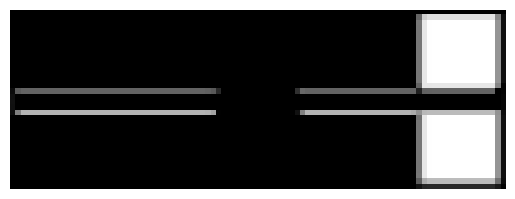

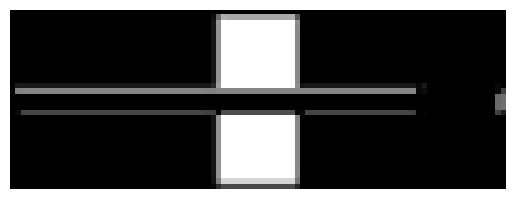

Best offset: (92, 0), score: 176643
Result:


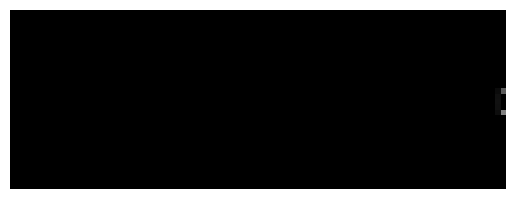

RuntimeError: sequence argument must have length equal to input rank

In [70]:
# New approach: Use Gradient Descent or similar to learn the parameters of the augmentation.
# We have base augmentations: Rotate, Flipping, Stretching, Cropping, Color change, and Translation. (Potential: bitwise logic like XOR)

def get_angle(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(-180, 180)
    best_angle = None
    best_score = float('inf')
    for angle in angles:
        score = augmentation_score(RotateAugmentation(angle), org, dest)
        if score < best_score:
            best_score = score
            best_angle = angle
    print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score

def get_offset(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    for dx in range(-width, width):
        for dy in range(-height, height):
            translated = shift(org, dx, dy) #ndimage.shift(org, (dy, dx))
            score = np.sum(np.abs(translated - dest))
            if score < best_score:
                best_score = score
                best_offset = (dx, dy)
    print(f"Best offset: {best_offset}, score: {best_score}")
    return best_offset, best_score

def get_offset_x(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    for dx in range(-width, width):
        translated = shift(org, dx, 0) #ndimage.shift(org, (dy, dx))
        score = np.sum(np.abs(translated - dest))
        if score < best_score:
            best_score = score
            best_offset = (dx, 0)
    print(f"Best offset: {best_offset}, score: {best_score}")
    return best_offset, best_score
def get_mirror_angle(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(0, 180)
    best_angle = None
    best_score = float('inf')
    for angle in angles:
        flipped = FlipAugmentation(angle)(org)
        score = np.sum(np.abs(flipped - dest))
        if score < best_score:
            best_score = score
            best_angle = angle
    print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score

def test_rotate():
    # Testing rotation
    org = imgs[0]
    dest = imgs[1]
    show_image(org)
    show_image(dest)
    print(get_angle(org, dest))

def test_translate():
    # Testing translation
    org = imgs[0]
    # translate org
    print(org.shape)
    dest = shift(org, 40, 10)
    show_image(org)
    show_image(dest)
    final_offset, score = get_offset(org, dest)
    aug_img = shift(org, final_offset[0], final_offset[1])
    print("Result:")
    show_image(aug_img)

def test_rotate_2():
    # Test on umbrella dataset, where it is impossible to get a score of zero
    data = iq_test_to_squares(get_image('iq_images/iq16.png'))
    org = data[0]
    dest = data[1]
    show_image(org)
    show_image(dest)
    angle, score = get_angle(org, dest)
    print(angle, score)
    aug_img = RotateAugmentation(angle)(org)
    show_image(aug_img)
    # try an angle of 90
    aug_img = RotateAugmentation(90)(org)
    show_image(aug_img)
    print(f"Angle 90 score: {np.sum(np.abs(aug_img - dest))}")

# This test shows removing the base can help get the correct change
# works from 0 to 1, not from 1 to 2
def test_rotate_3():
    # test on clocks dataset, but first remove the commonalities (bitwise and)
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    # remove commonalities
    base = cv2.bitwise_and(org, dest)
    org = cv2.bitwise_xor(org, base)
    dest = cv2.bitwise_xor(dest, base)
    show_image(org)
    show_image(dest)
    angle, score = get_angle(org, dest)
    print(angle, score)
    aug_img = RotateAugmentation(angle)(org)
    show_image(aug_img)
    angle_test = 90
    print(f"Trying an angle of {angle_test}")
    aug_img = RotateAugmentation(angle_test)(org)
    show_image(aug_img)
    print(f"Angle {angle_test} score: {np.sum(np.abs(aug_img - dest))}")

# Similar to test 3, but now try to center the images
def test_rotate_4():
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    
    show_image(org)
    show_image(dest)
    org, dest = align_images(org, dest)
    # Need them to have the same size
    org = cv2.resize(org, (dest.shape[1], dest.shape[0]))
    print("Remove commonality")
    # remove commonalities
    base = cv2.bitwise_and(org, dest)
    org = cv2.bitwise_xor(org, base)
    dest = cv2.bitwise_xor(dest, base)
    show_image(org)
    show_image(dest)
    angle, score = get_angle(org, dest)
    print(angle, score)
    aug_img = RotateAugmentation(angle)(org)
    show_image(aug_img)
    angle_test = 90
    print(f"Trying an angle of {angle_test}")
    aug_img = RotateAugmentation(angle_test)(org)
    show_image(aug_img)
    # print(f"Angle {angle_test} score: {np.sum(np.abs(aug_img - dest) ** 2)}")

    # Try plotting the score for different angles
    angles = range(-180, 180)
    scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.plot(angles, scores)
    plt.show()
    # create a mapping from angle to score
    angle_score_map = {angle: score for angle, score in zip(angles, scores)}
    return angle_score_map


# Try to translate test 4
def test_translate_2():
    # Testing translation
    data = iq_test_to_squares(get_image('iq_images/iq04.png'))
    org = data[0]
    dest = data[1]
    org, dest = align_images(org, dest, True)
    org, dest = remove_background(org, dest)
    show_image(org)
    show_image(dest)
    final_offset, score = get_offset_x(org, dest)
    aug_img = shift(org, final_offset[0], final_offset[1])
    print("Result:")
    show_image(aug_img)
    # test_shift = (10, 10)
    # Try plotting the score for different offsets
    offset_x = range(-org.shape[1], org.shape[1])
    scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.plot(offset_x, scores)
    plt.show()


# map = test_rotate_4()
test_translate_2()

In [68]:
print(map[0])
print(map[89])
print(map[90])
print(map[-90])
print(map[-89])

21.575141776937617
17.730151228733458
15.477315689981097
17.119801512287335
19.229796786389414


Original, Horizontal line flipped Original


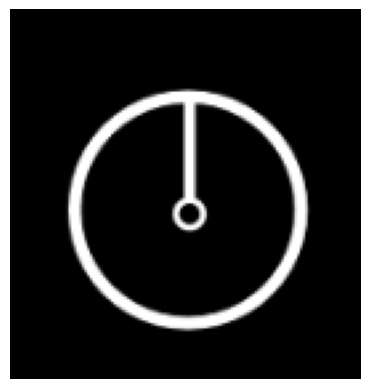

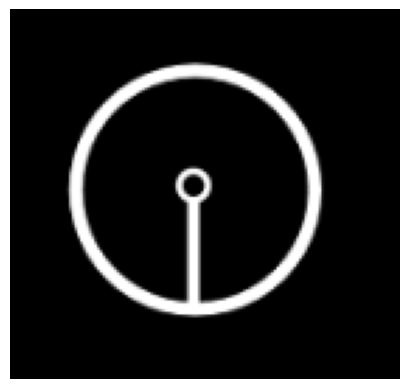

SyntaxError: 'return' outside function (3408502639.py, line 12)

In [9]:

names = ["Rotate 45 CW", "Rotate 90 CW", "Flip Horizontal", "Flip Vertical", "Rotate 45 CCW", "Rotate 90 CCW"]
augmentations = [RotateAugmentation(45), RotateAugmentation(90), FlipAugmentation(90), FlipAugmentation(0), RotateAugmentation(-45), RotateAugmentation(-90)]

left_to_right_transitions = [[(imgs[0], imgs[1]), (imgs[1], imgs[2])], [(imgs[3], imgs[4]), (imgs[4], imgs[5])], [(imgs[6], imgs[7]), (imgs[7], imgs[8])]]

# Look at a vertical flip from 0 to 1
print("Original, Horizontal line flipped Original")

show_image(imgs[0])
show_image(FlipAugmentation(180)(imgs[0]))

return

for name, aug in zip(names, augmentations):
    print(name)
    scores = [[augmentation_score(aug, img1, img2) for img1, img2 in row] for row in left_to_right_transitions]
    scores[2][1] = 0 # No transition for the last cell
    print(scores)

# Actual pattern:
# Rotate 45, Rotate 90
# (from row 1 to row 2)

# Look at how a rotate of 45 degrees from 0 to 1 looks like
print("Original, Destination, Augmented Original")
names = ["From 0 to 1", "From 1 to 2"]
ids = [(0, 1), (1, 2)]
augmentations = [("Rotate 45", RotateAugmentation(45)), ("Rotate 90", RotateAugmentation(90))]
augmentations = [("Rotate 90 CW", RotateAugmentation(90)), ("Rotate 90 CCW", RotateAugmentation(-90))]
augmentations = [("Flip horiz", FlipAugmentation(90)), ("Flip vertical", FlipAugmentation(0))]
for names, id in zip(names, ids):
    print(names)
    first, second = id
    for desc, aug in augmentations:
        print(desc)
        show_image(imgs[first])
        show_image(imgs[second])
        show_image(aug(imgs[first]))
        print(f"Score = {augmentation_score(aug, imgs[first], imgs[second])}")

show_images_grid(imgs)


In [ ]:
# New approach: Use Gradient Descent or similar to learn the parameters of the augmentation.
# We have base augmentations: Rotate, Flipping, Stretching, Cropping, Color change, and Translation. (Potential: bitwise logic like XOR)
